In [27]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import importlib
import pandas as pd
import matplotlib.gridspec as gridspec
import time

import sys
sys.path.append('../scripts')

import sirs
import params
import plotting
from params import cols

from pylab import cm
import matplotlib as mpl
from matplotlib import colors
from scipy.signal import find_peaks

plotting.set_rcParams()

In [4]:
# Colormaps for the costs

cmapI = colors.LinearSegmentedColormap.from_list("",['lightgrey','mediumvioletred'])
my_cmapI = cmapI(np.arange(cmapI.N))
my_cmapI[:,-1] = np.linspace(0, 1, cmapI.N)
my_cmapI = colors.ListedColormap(my_cmapI)

cmapM = colors.LinearSegmentedColormap.from_list("",['lightgrey','forestgreen'])
my_cmapM = cmapM(np.arange(cmapM.N))
my_cmapM[:,-1] = np.linspace(0, 1, cmapM.N)
my_cmapM = colors.ListedColormap(my_cmapM)

In [38]:
# Create a matrix from the .dat file. Note that the .dat file already contains the cost values 

def get_costmatrix(res,param='mmax',cost='av_I'):
    
    tauline = np.sort(list(set(res['tau'])))
    sline = np.flip(np.sort(list(set(res[param]))))

    M = np.zeros([len(sline),len(tauline)])

    for i,tau in enumerate(tauline):
        subres = res[res['tau']==tau]
        for j,s in enumerate(sline):
            subsubres = subres[subres[param]==s]

            c = np.array(subsubres[cost])[0]
            M[j,i] = c
    Mrev = M.copy()
    return Mrev,tauline,sline

The data file used here was created using a C script that simulated timeseries in the $\tau$-$m_{max}$ plane. It directly computed the costs according to the definition in the paper. 

In [39]:
arnold = '../simulations/cluster/arnoldtongues/arnold_mmax=07-1_tau=0-50_a=025.dat'
res_a = pd.read_csv(arnold,sep=',')

res = pd.read_table(arnold,sep=',')
res = res[res['tau']!=0.1]
res = res[res['Mmax']>=0.75]

M_I, tauline, mmaxline = get_costmatrix(res,param='Mmax')
M_m, tauline, mmaxline = get_costmatrix(res,param='Mmax',cost='av_cost_m')



In [40]:
#Weightings of the costs 

kappa = 1
kappa_r = 1/5

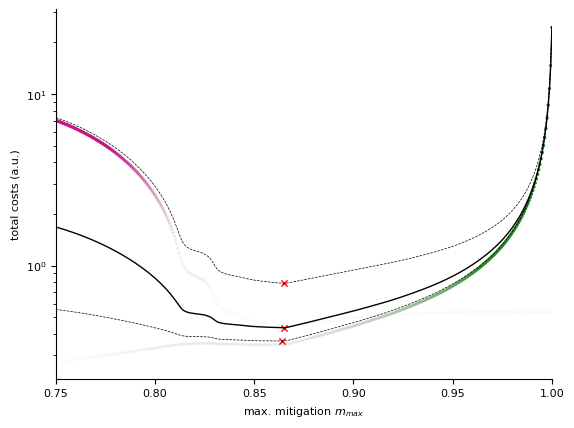

In [37]:
fig, ax = plt.subplots()


x1 = 0.75
x2 = 1
tau1d = 15

y_I = M_I[round(np.shape(M_I)[0]*(1-x2)/0.25):round(np.shape(M_I)[0]*(1-x1)/0.25),round(tau1d/50*np.shape(M_I)[1])]
y_m = M_m[round(np.shape(M_m)[0]*(1-x2)/0.25):round(np.shape(M_m)[0]*(1-x1)/0.25),round(tau1d/50*np.shape(M_m)[1])]
x = np.linspace(x1,x2,len(y_I))


ax.scatter(x,500*kappa*np.flip(y_I),c=100*kappa*np.flip(y_I),cmap=cmapI,s=2,vmax=1)
ax.scatter(x,kappa_r*np.flip(y_m),c=np.flip(y_m),cmap=cmapM,s=2,vmax=10)

for weighting,ls,lw in zip([100,20,500],['-','--','--'],[1,0.5,0.5]):
    ax.plot(x,np.flip(weighting*kappa*y_I+kappa_r*y_m),color="black",lw=lw,ls=ls)
    ax.scatter(x[np.argmin(np.flip(weighting*kappa*y_I+kappa_r*y_m))],\
               np.min(np.flip(weighting*kappa*y_I+kappa_r*y_m)),color="red",s=20,marker="x",linewidths=1)
    

ax.set_xlabel('max. mitigation $m_{max}$')
ax.set_ylabel('total costs (a.u.)')

ax.set_xlim(0.75,1)

ax.set_yscale('log')

### Costs in $\tau$-$m_{max}$ plane (overlayed)

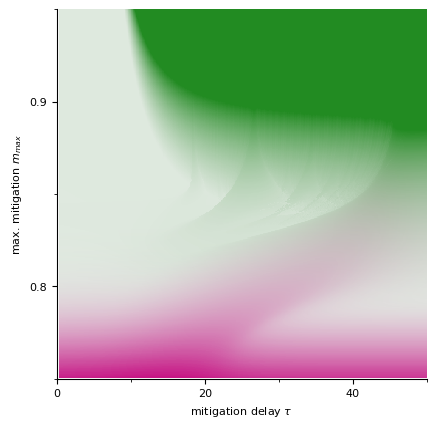

In [36]:
fig,ax = plt.subplots()


dia3 = ax.imshow(M_I,aspect='auto', extent=(tauline.min(), tauline.max(), mmaxline.min(), mmaxline.max()), \
          cmap=my_cmapI, interpolation='None',alpha=1)
dia4 = ax.imshow(M_m,aspect='auto', extent=(tauline.min(), tauline.max(), mmaxline.min(), mmaxline.max()), \
          cmap=my_cmapM, vmax=5, interpolation='None',alpha=1)

ax.set_xlabel(r'mitigation delay $\tau$')
ax.set_ylabel('max. mitigation $m_{max}$')

ax.set_xticks([0,20,40],minor=False)
ax.set_xticks([10,30,50],minor=True)
ax.set_xlim(0,50)
ax.set_yticks([0.8,0.9])
ax.set_yticks([0.75,0.85,0.95],minor=True)
ax.set_ylim(None,0.95)
ax.set_aspect(1/ax.get_data_ratio(),adjustable='box')


### Overlaying costs onto Arnold tongues and cost minima

In [28]:
# Code to find the cost minima for a range of tau values

def find_minima(arr):
    # Invert the array to find minima as maxima
    inverted_arr = -arr
    
    # Find peaks in the inverted array
    peaks, _ = find_peaks(inverted_arr,distance=len(arr)/5,prominence=0.2)
    
    # Get the positions and values of the minima
    minima_positions = peaks
    minima_values = arr[minima_positions]
    
    # Sort minima by their values
    sorted_indices = np.argsort(minima_values)
    minima_positions = minima_positions[sorted_indices]
    minima_values = minima_values[sorted_indices]
    
    return minima_positions, minima_values

In [29]:

evaluate_tau = np.arange(10,50,2)
minimalcosts = []
minimalcosts_values = []

x1 = 0.75
x2 = 1
x = np.linspace(x1,x2,len(y_I))
weighting = 100

for tau1d in evaluate_tau:
    y_m = M_m[round(np.shape(M_m)[0]*(1-x2)/0.25):round(np.shape(M_m)[0]*(1-x1)/0.25),round(tau1d/50*np.shape(M_m)[1])]
    y_I = M_I[round(np.shape(M_I)[0]*(1-x2)/0.25):round(np.shape(M_I)[0]*(1-x1)/0.25),round(tau1d/50*np.shape(M_I)[1])]
    kappa_r = 0.1
    ax.scatter(x,100*kappa*np.flip(y_I),c=100*kappa*np.flip(y_I),cmap=cmapI,s=2,vmax=1)
    ax.scatter(x,kappa_r*np.flip(y_m),c=np.flip(y_m),cmap=cmapM,s=2,vmax=10)
    
    totalcosts = np.flip(weighting*kappa*y_I+kappa_r*y_m)
    
    ax.plot(x,totalcosts,color="black",lw=lw,ls=ls)
    ax.scatter(x[np.argmin(totalcosts)],\
               np.min(np.flip(weighting*kappa*y_I+kappa_r*y_m)),color="red",s=12)
    
    minima_positions, minima_values = find_minima(totalcosts)
    ax.scatter(x[minima_positions], minima_values,color='blue',s=12)
    
    minimalcosts.append(x[minima_positions])
    minimalcosts_values.append(minima_values)



In [18]:
windingnumbers,windingnumberlabels,cmap = plotting.get_arnold_cmap()

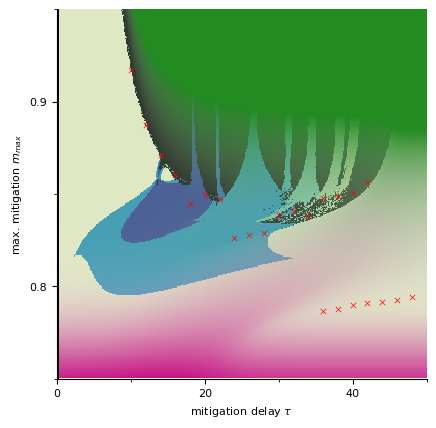

In [31]:
fig, ax = plt.subplots()


dia_arnold = plotting.plot_arnold(ax,res_a,cmap=cmap,param="Mmax",windingnumbers=windingnumbers)

dia3 = ax.imshow(M_I,aspect='auto', extent=(tauline.min(), tauline.max(), mmaxline.min(), mmaxline.max()), \
          cmap=my_cmapI, interpolation='None',alpha=1)
dia4 = ax.imshow(M_m,aspect='auto', extent=(tauline.min(), tauline.max(), mmaxline.min(), mmaxline.max()), \
          cmap=my_cmapM, vmax=5, interpolation='None',alpha=1)

ax.set_xlabel(r'mitigation delay $\tau$')
ax.set_ylabel('max. mitigation $m_{max}$')

ax.set_xticks([0,20,40],minor=False)
ax.set_xticks([10,30,50],minor=True)
ax.set_xlim(0,50)
ax.set_yticks([0.8,0.9])
ax.set_yticks([0.75,0.85,0.95],minor=True)
ax.set_ylim(None,0.95)
ax.set_aspect(1/ax.get_data_ratio(),adjustable='box')


for x,y in zip(evaluate_tau,minimalcosts):
    ax.scatter([x]*len(y),y,color='red',s=15,marker='x',linewidths=0.5,zorder=5)
